# Introduction 

Elasticsearch est un moteur de recherche temps réel et Open Source. 
Il possède de nombreux avantages : 
- il met en place une API RESTful.
- il est distribué, ce qui lui permet d'être tolérant aux pannes.
- il est basé sur le moteur d'indexation d'Apache Lucène.
- utilise le format JSON pour le stockage
- permet de faire de la recherche en texte libre. 

Il est utilisé dans de nombreuses entreprises pour faire de la recherche textuelle dans des documents ou alors traiter des tera de logs. 

Dans ce cours nous allons aborder deux technologies, ElasticSearch et Kibana. 

## Concepts

- `Near Realtime (NRT)` : La plupart des anciens moteurs de recherche devaient processer et indexer les documents pour qu'ils puissent être recherchés. ElasticSearch permet de rechercher les nouveaux documents presque instantanément.  


- `Document` : Le document est l'unité de base  qui peut être indexé dans ElasticSearch. Un document est représenté au format JSON. On peut stocker autant de document que l'on souhaite dans un index. Un document est un ensemble de données clés-valeurs.   


- `Index` : Un index est une collection de documents qui ont des caractéristiques similaires. Un index est identifié par un nom. On peut créer autant d'index que l'on veut.   


- `Node` : Un Node (ou noeud en francais) est un serveur qui fait parti d'un cluster de plusieurs noeuds. Un noeud stocke les données et est optimisé pour retrouver les données.   


- `Cluster` : Un cluster est un ensemble de noeud qui communiquent entre eux.  Un cluster peut contenir autant de noeuds que l'on veut.   


- `Shards` :  Un index peut être tellement gros que la donnée des documents est plus importante que la capacité de stockage d'un node et donc d'un serveur. Pour pallier ce problème ElasticSearch met en place une méthode pour découper la données des index en des nombreuses petites parties qui sont appelés des shards. Chaque shard est stocké sur un noeud différents. 

    Cette technique est intéressante car elle permet de scaler horizontalement notre cluster (ie: augmenter le nombre de machines et donc de noeuds)  
    

- `Replicas` : Comme chaque noeud ne contient pas l'intégralité des données, on pourrait penser que si un noeud tombe en panne, une partie des données serait perdue. ElasticSearch met en place une technique de réplication qui permet de stocker ces différents shards sur plusieurs noeuds. C'est la **réplication**.  
    
    Cette technique est particulièrement intéressante puisqu'elle permet de palier la panne de shards ou de noeuds.

# Let's Play 

In [3]:
from elasticsearch import Elasticsearch

LOCAL = False

es_client = Elasticsearch(hosts=["localhost" if LOCAL else "elasticsearch"])

In [4]:
es_client.ping()

True

Pour indexer des documents, il suffit d'appeler la méthode `index` du client.

In [5]:
document = {
    "name":"Decision Trees", 
    "description":"A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance-event outcomes, resource costs, and utility. Take a look at the image to get a sense of how it looks like.",
    "algo_type":"Supervised Learning"
}

In [6]:
res = es_client.index(index="algorithms", doc_type='algo', id=1, body=document)
print(res['result'])

created


Le document à été créé avec succès, on peut maintenant le récupérer via son index. 

In [7]:
import pprint

In [8]:
res = es_client.get(index="algorithms", doc_type='algo', id=1)
pprint.pprint(res["_source"])

{'algo_type': 'Supervised Learning',
 'description': 'A decision tree is a decision support tool that uses a '
                'tree-like graph or model of decisions and their possible '
                'consequences, including chance-event outcomes, resource '
                'costs, and utility. Take a look at the image to get a sense '
                'of how it looks like.',
 'name': 'Decision Trees'}


In [22]:
documents = [
    {
    "name":"Naive Bayes Classification", 
    "description":"Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. The featured image is the equation — with P(A|B) is posterior probability, P(B|A) is likelihood, P(A) is class prior probability, and P(B) is predictor prior probability.",
    "algo_type":"Supervised Learning"
    },    {
    "name":"Logistic Regression", 
    "description":"Logistic regression is a powerful statistical way of modeling a binomial outcome with one or more explanatory variables. It measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic function, which is the cumulative logistic distribution.",
    "algo_type":"Supervised Learning"
},    {
    "name":"Principal Component Analysis", 
    "description":"PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.",
    "algo_type":"Unsupervised Learning"
},    {
    "name":"Singular Value Decomposition", 
    "description":"In linear algebra, SVD is a factorization of a real complex matrix. For a given m * n matrix M, there exists a decomposition such that M = UΣV, where U and V are unitary matrices and Σ is a diagonal matrix.",
    "algo_type":"Unsupervised Learning"
}
]

Si on ne précise pas l'ID lors de l'indexation, ElasticSearch se charge d'en trouver un automatiquement

In [23]:
for doc in documents:
    res = es_client.index(index="algorithms", doc_type='algo', id=None, body=doc)
    print(res["result"])

created
created
created
created


On récupère maintenant tous les éléments de l'index

In [25]:
result = es_client.search(index="algorithms", body={"query": {"match_all": {}}})
result

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 9, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'algorithms',
    '_type': 'algo',
    '_id': '1',
    '_score': 1.0,
    '_source': {'name': 'Decision Trees',
     'description': 'A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance-event outcomes, resource costs, and utility. Take a look at the image to get a sense of how it looks like.',
     'algo_type': 'Supervised Learning'}},
   {'_index': 'algorithms',
    '_type': 'algo',
    '_id': 'AD34nW4BAp4dGgoeMiUJ',
    '_score': 1.0,
    '_source': {'name': 'Naive Bayes Classification',
     'description': 'Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. The featured image is the

La réponse nous donne des informations sur le temps d'exécution de la requête le nombre de documents correspondant à la requête et l'ensemble des documents. 

In [26]:
N_DOCS = result['hits']['total']['value']
f"{N_DOCS} document{'s' if N_DOCS> 1 else '' } correspondent à la requêtes qui a pris {result['took']} ms"

'9 documents correspondent à la requêtes qui a pris 1 ms'

Affichons maintenant tous les documents : 

In [27]:
ids = []
for hit in result['hits']['hits']:
    print("Name : {name}\n description : {description} \n Type : {algo_type}\n".format(**hit['_source']))
    print("******************")
    ids.append(hit["_id"])

Name : Decision Trees
 description : A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance-event outcomes, resource costs, and utility. Take a look at the image to get a sense of how it looks like. 
 Type : Supervised Learning

******************
Name : Naive Bayes Classification
 description : Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. The featured image is the equation — with P(A|B) is posterior probability, P(B|A) is likelihood, P(A) is class prior probability, and P(B) is predictor prior probability. 
 Type : Supervised Learning

******************
Name : Logistic Regression
 description : Logistic regression is a powerful statistical way of modeling a binomial outcome with one or more explanatory variables. It measures the relationship between the categorical depend

Pour supprimer un document il suffit d'appeler la méthode `delete`.

In [28]:
es_client.delete(index="algorithms", doc_type="algo", id=ids[0])

{'_index': 'algorithms',
 '_type': 'algo',
 '_id': '1',
 '_version': 2,
 'result': 'deleted',
 '_shards': {'total': 2, 'successful': 1, 'failed': 0},
 '_seq_no': 9,
 '_primary_term': 1}

In [30]:
N_DOCS = result['hits']['total']['value']
f"{N_DOCS} document{'s' if N_DOCS> 1 else '' } correspondent à la requêtes qui a pris {result['took']} ms"

'8 documents correspondent à la requêtes qui a pris 1 ms'

Faisons des choses un peu plus intéressantes maintenant.   

Dans le répertoire `data/` il y a les données de 5000 films de la base de TMDb. 

## Nettoyage

Avant de commencer il faut nettoyer un peu les données du fichier csv.

In [31]:
import pandas as pd
import json
df_movies = pd.read_csv("./data/tmdb_5000_movies.csv")

In [32]:
def clean_words(l):
    return [elt["name"] for elt in json.loads(l)]

On nettoie alors la donnée des colonnes.

In [33]:
for col in ["genres", "keywords", "production_countries", "spoken_languages"]:
    df_movies.loc[:,col] = df_movies.loc[:,col].apply(clean_words)

Pour indexer les documents il nous faut une liste de dictionnaires. Pour cela on peut utiliser la méthode de pandas `to_dict` avec le paramètre `orient=records`.

In [34]:
documents = df_movies.fillna("").to_dict(orient="records")

In [35]:
documents[0:2]

[{'budget': 237000000,
  'genres': ['Action', 'Adventure', 'Fantasy', 'Science Fiction'],
  'homepage': 'http://www.avatarmovie.com/',
  'id': 19995,
  'keywords': ['culture clash',
   'future',
   'space war',
   'space colony',
   'society',
   'space travel',
   'futuristic',
   'romance',
   'space',
   'alien',
   'tribe',
   'alien planet',
   'cgi',
   'marine',
   'soldier',
   'battle',
   'love affair',
   'anti war',
   'power relations',
   'mind and soul',
   '3d'],
  'original_language': 'en',
  'original_title': 'Avatar',
  'overview': 'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.',
  'popularity': 150.437577,
  'production_companies': '[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]',
  '

Pour éviter de faire plein de petits appels à ElasticSearch pour indexer les 5000 films on peut utiliser un helper `bulk` pour indexer tous les documents d'un seul coup et éviter les appels réseaux qui sont très couteux en temps. 

In [36]:
from elasticsearch.helpers import bulk

In [37]:
import numpy as np

In [38]:
def generate_data(documents):
    for docu in documents:
        yield {
            "_index": "movies",
            "_type": "movie",
            "_source": {k:v if v else None for k,v in docu.items()},
        }

bulk(es_client, generate_data(documents))

(4803, [])

On peut utiliser l'interface http pour vérifier que les index sont bien à jours. L'index `movies` est présent on peut aussi voir le nombre de documents et la taille en mémoire.  

In [39]:
!curl http://localhost:9200/_cat/indices?v #!curl http://elasticsearch:9200/_cat/indices?v

curl: (7) Failed to connect to localhost port 9200: Connection refused


On peut voir aussi quelques documents avec le endpoint HTTP suivant

In [40]:
!curl http://localhost:9200/movies/_search #!curl http://elasticsearch:9200/movies/_search

curl: (7) Failed to connect to localhost port 9200: Connection refused


# Kibana 

In [41]:
from IPython.display import Image

C'est le moment de commencer à utiliser Kibana. Kibana est un soft de la suite ELK (ElasticSearch, Kibana, Logstash) qui permet de gérer de façon graphique les données dans les index ElasticSearch.

## Index Pattern

Dans l'onglet `Management`, il faut spécifier à Kibana d'aller chercher un index spécifique sur ElasticSearch. Aller dans `Create index pattern` et taper les premières lettres du nom de l'index que vous voulez parcourir. Ici `movies`, vous verrez alors la page suivante, référençant l'intégralité des champs de l'index. 

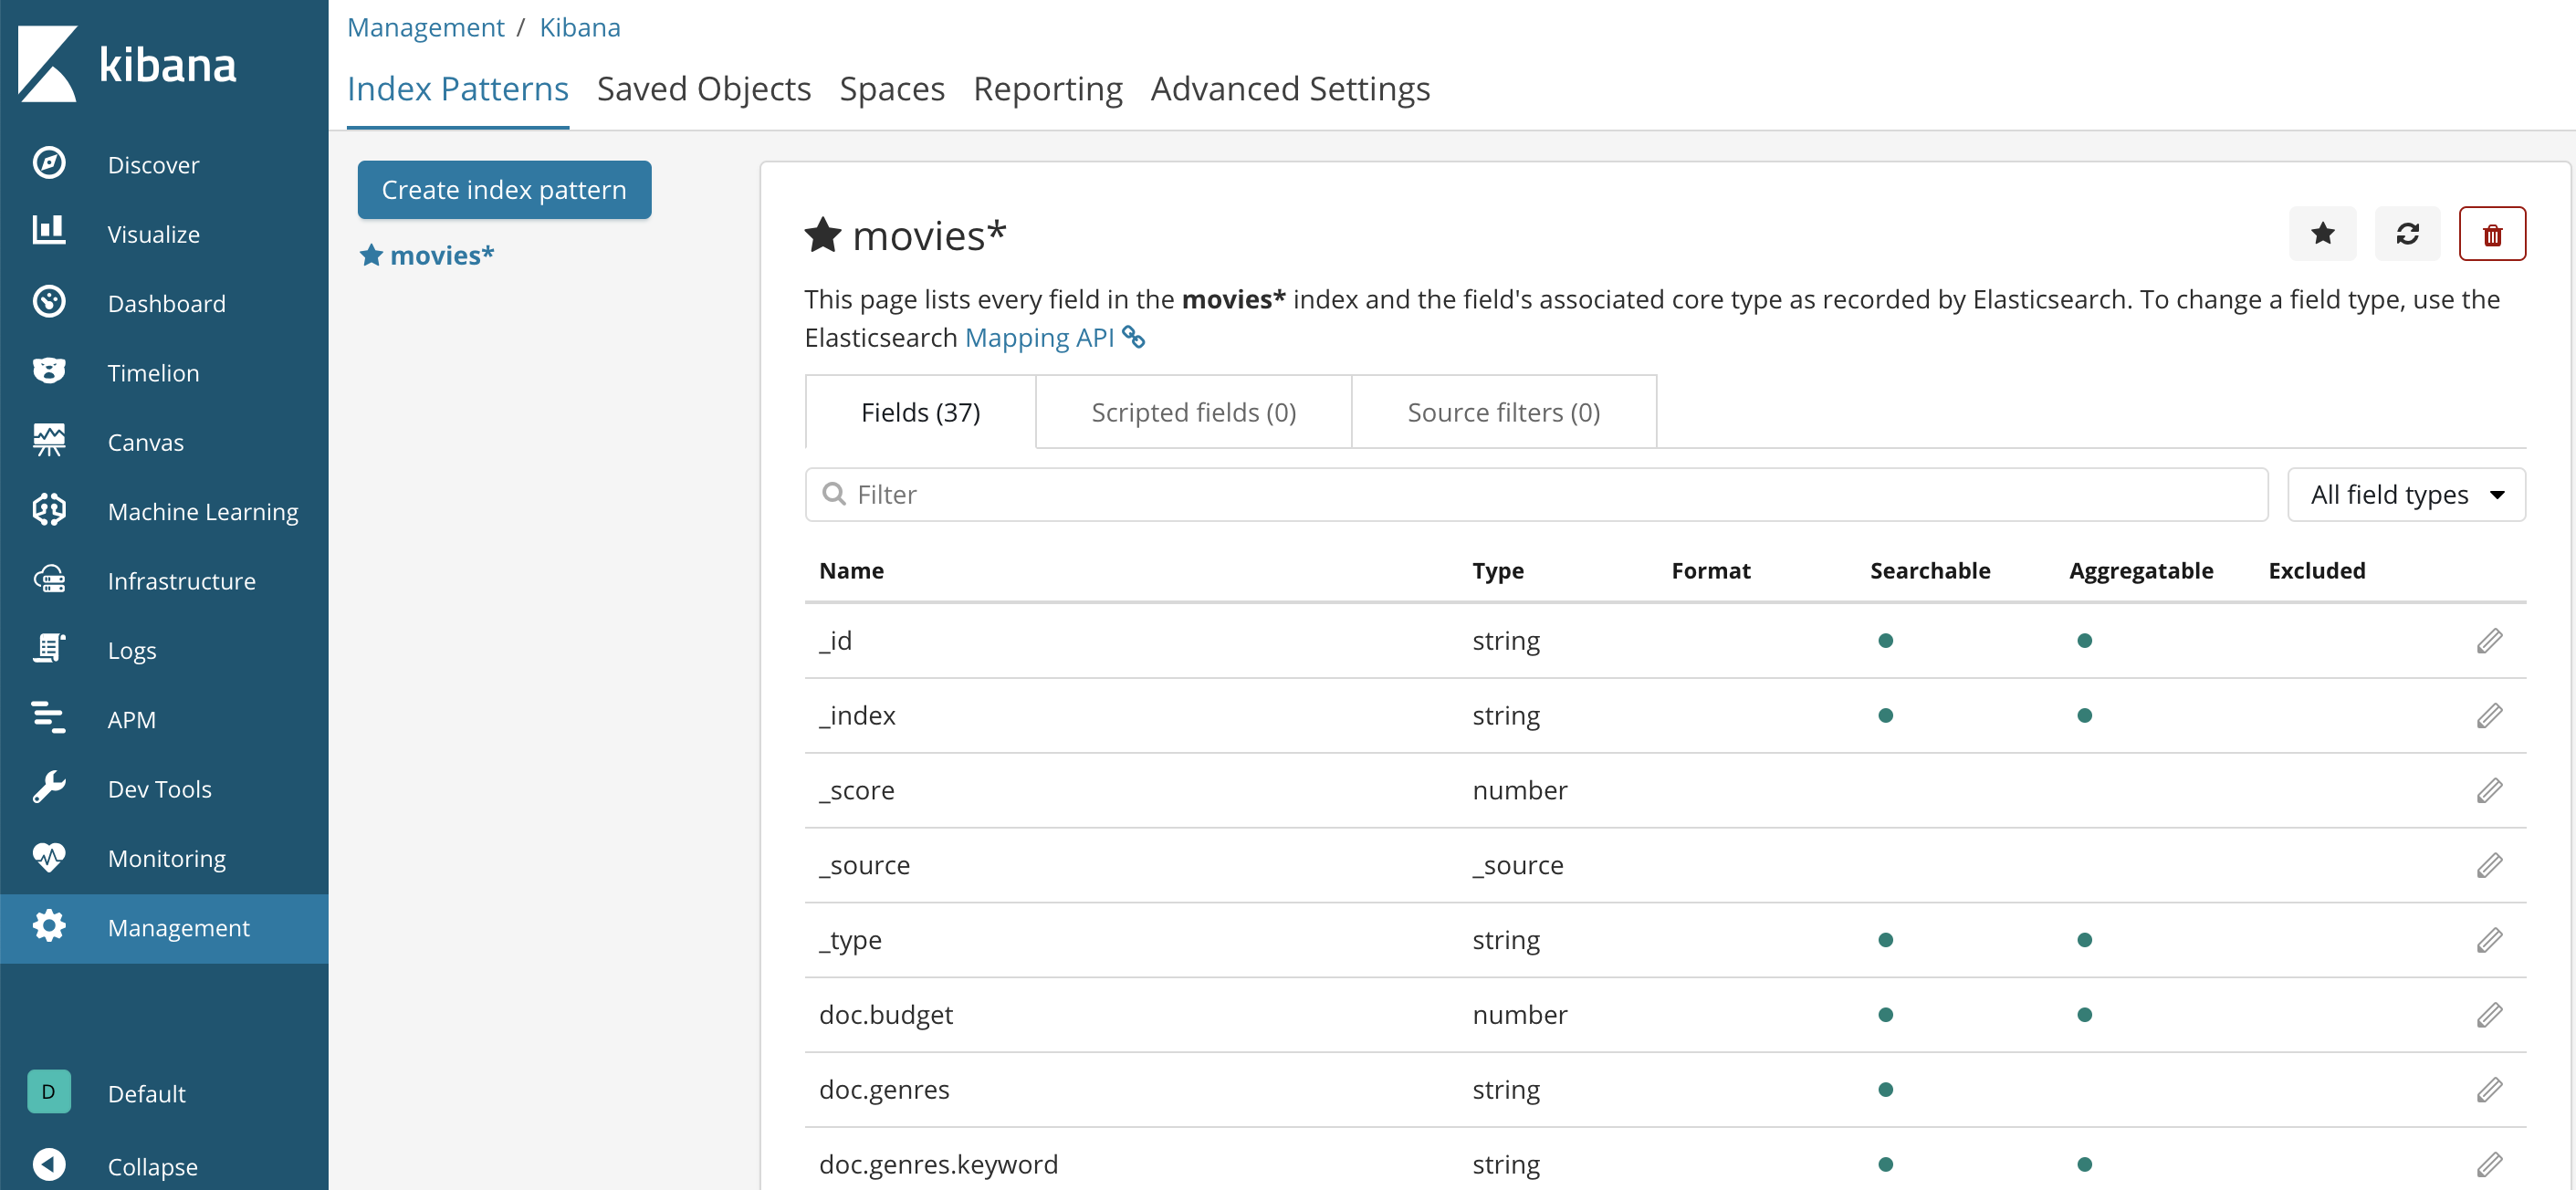

In [42]:
Image("./img/index_pattern.png")

Vous pouvez ensuite aller dans l'onglet `Discover` pour voir un apperçu des documents que vous venez d'indexer. Vous pouvez aussi, sur la droite, appliquer des filtres pour faire des requêtes simples sur vos données. Ici on appliquera un filtre sur le genre `Comedy`.

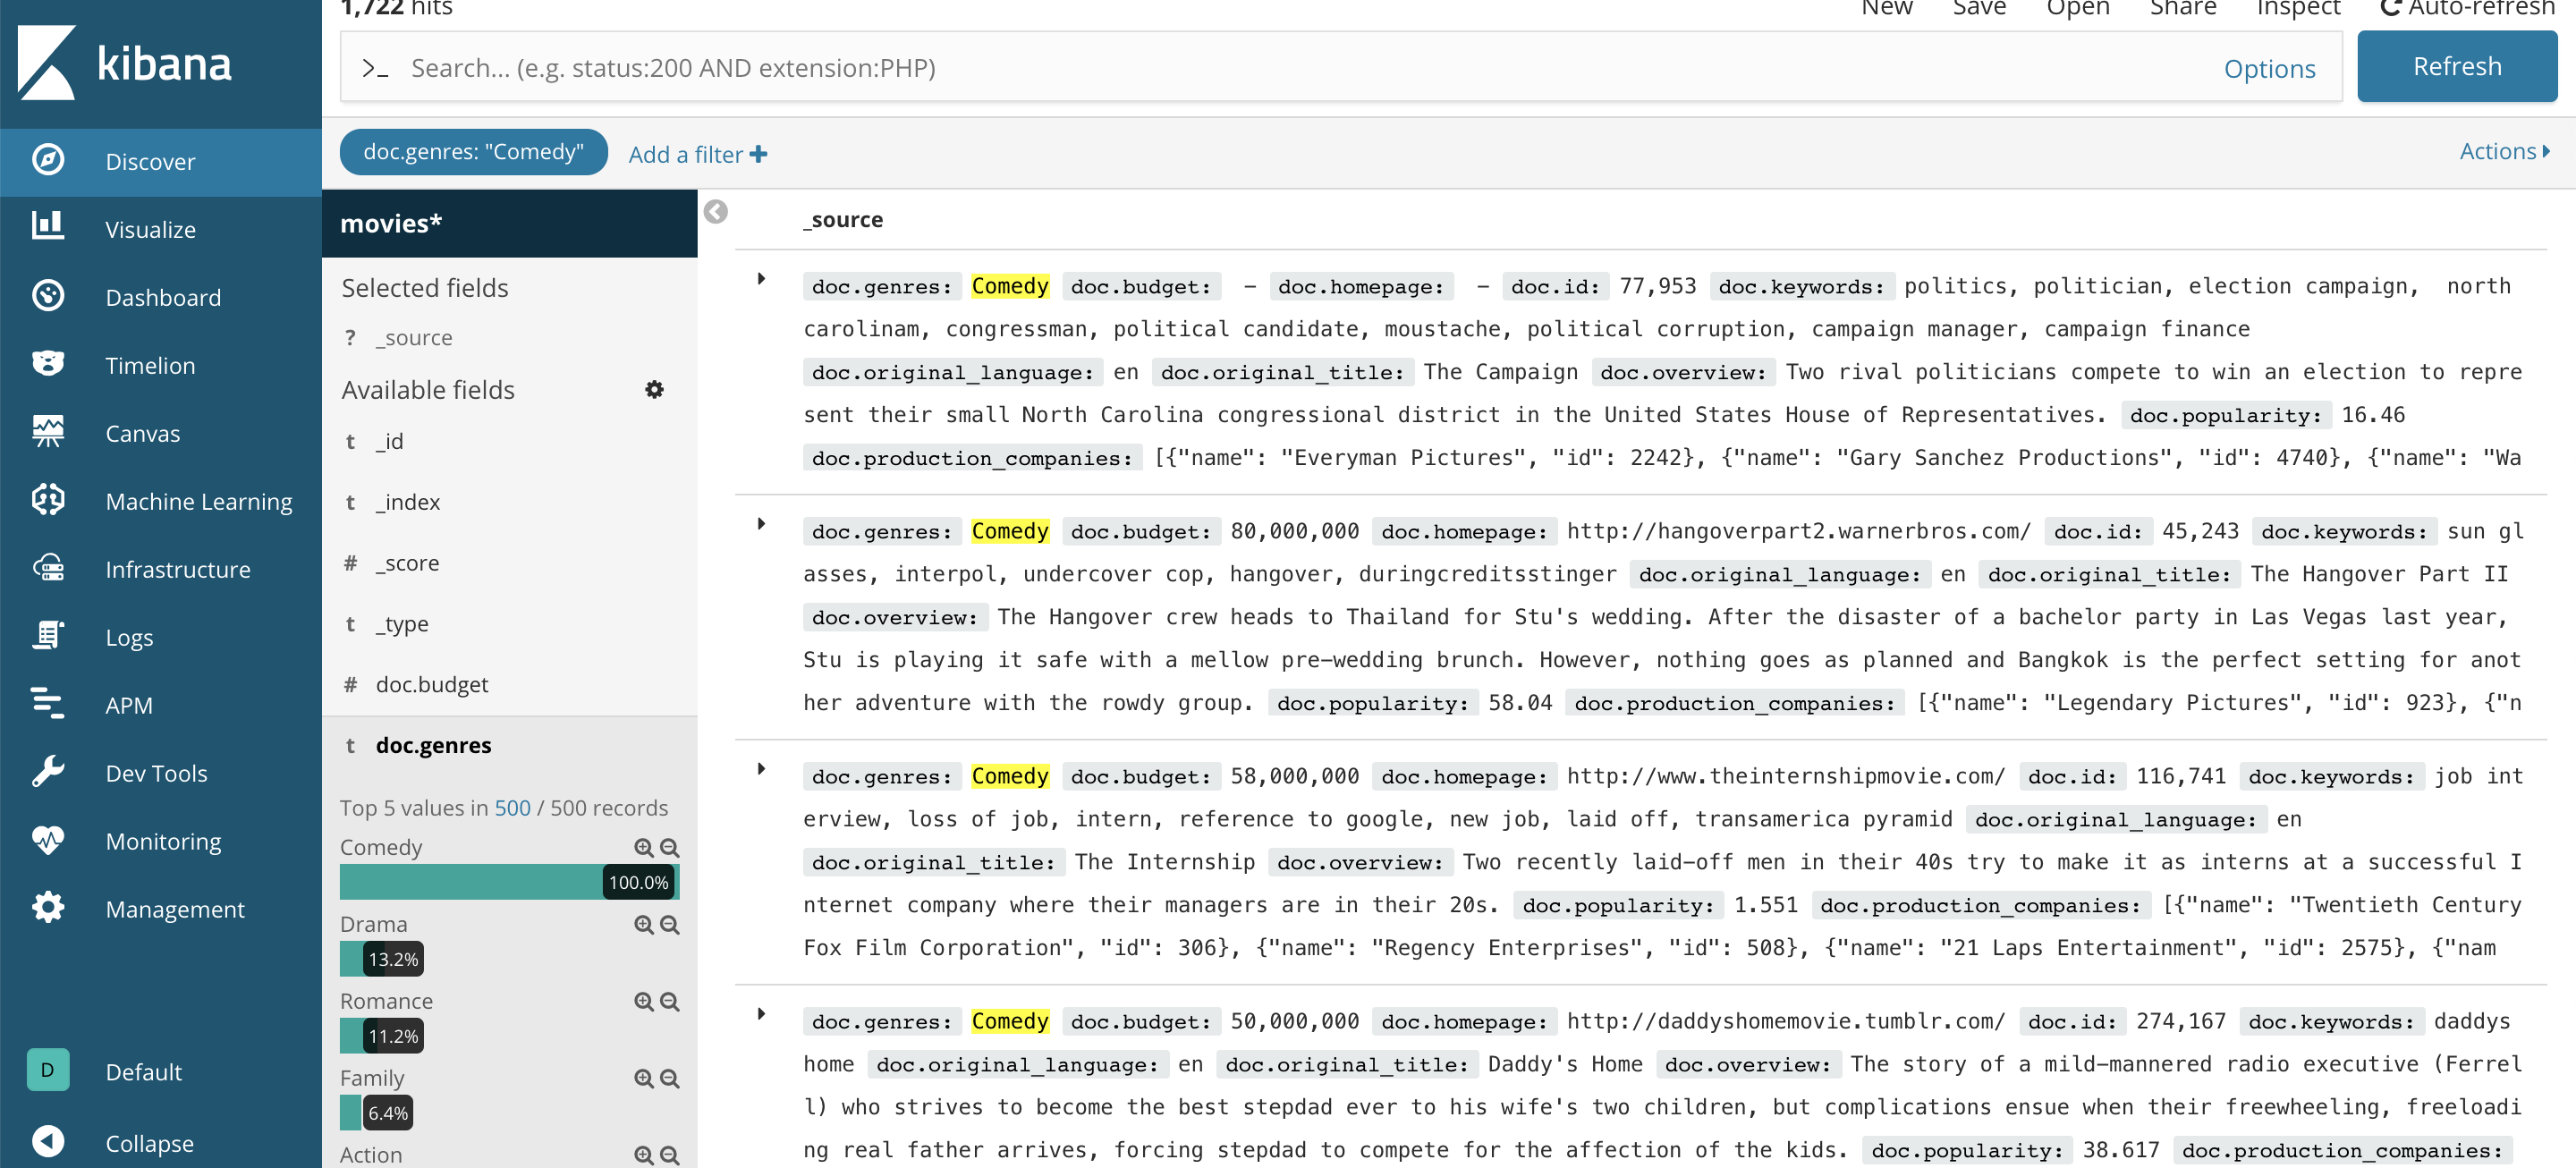

In [43]:
Image("./img/discover.png")

Vous pouvez aller ensuite dans l'onglet `Visualize` pour commencer à jouer avec les graphiques. Par exemple on peut créer un histograme des budgets des différents films. 

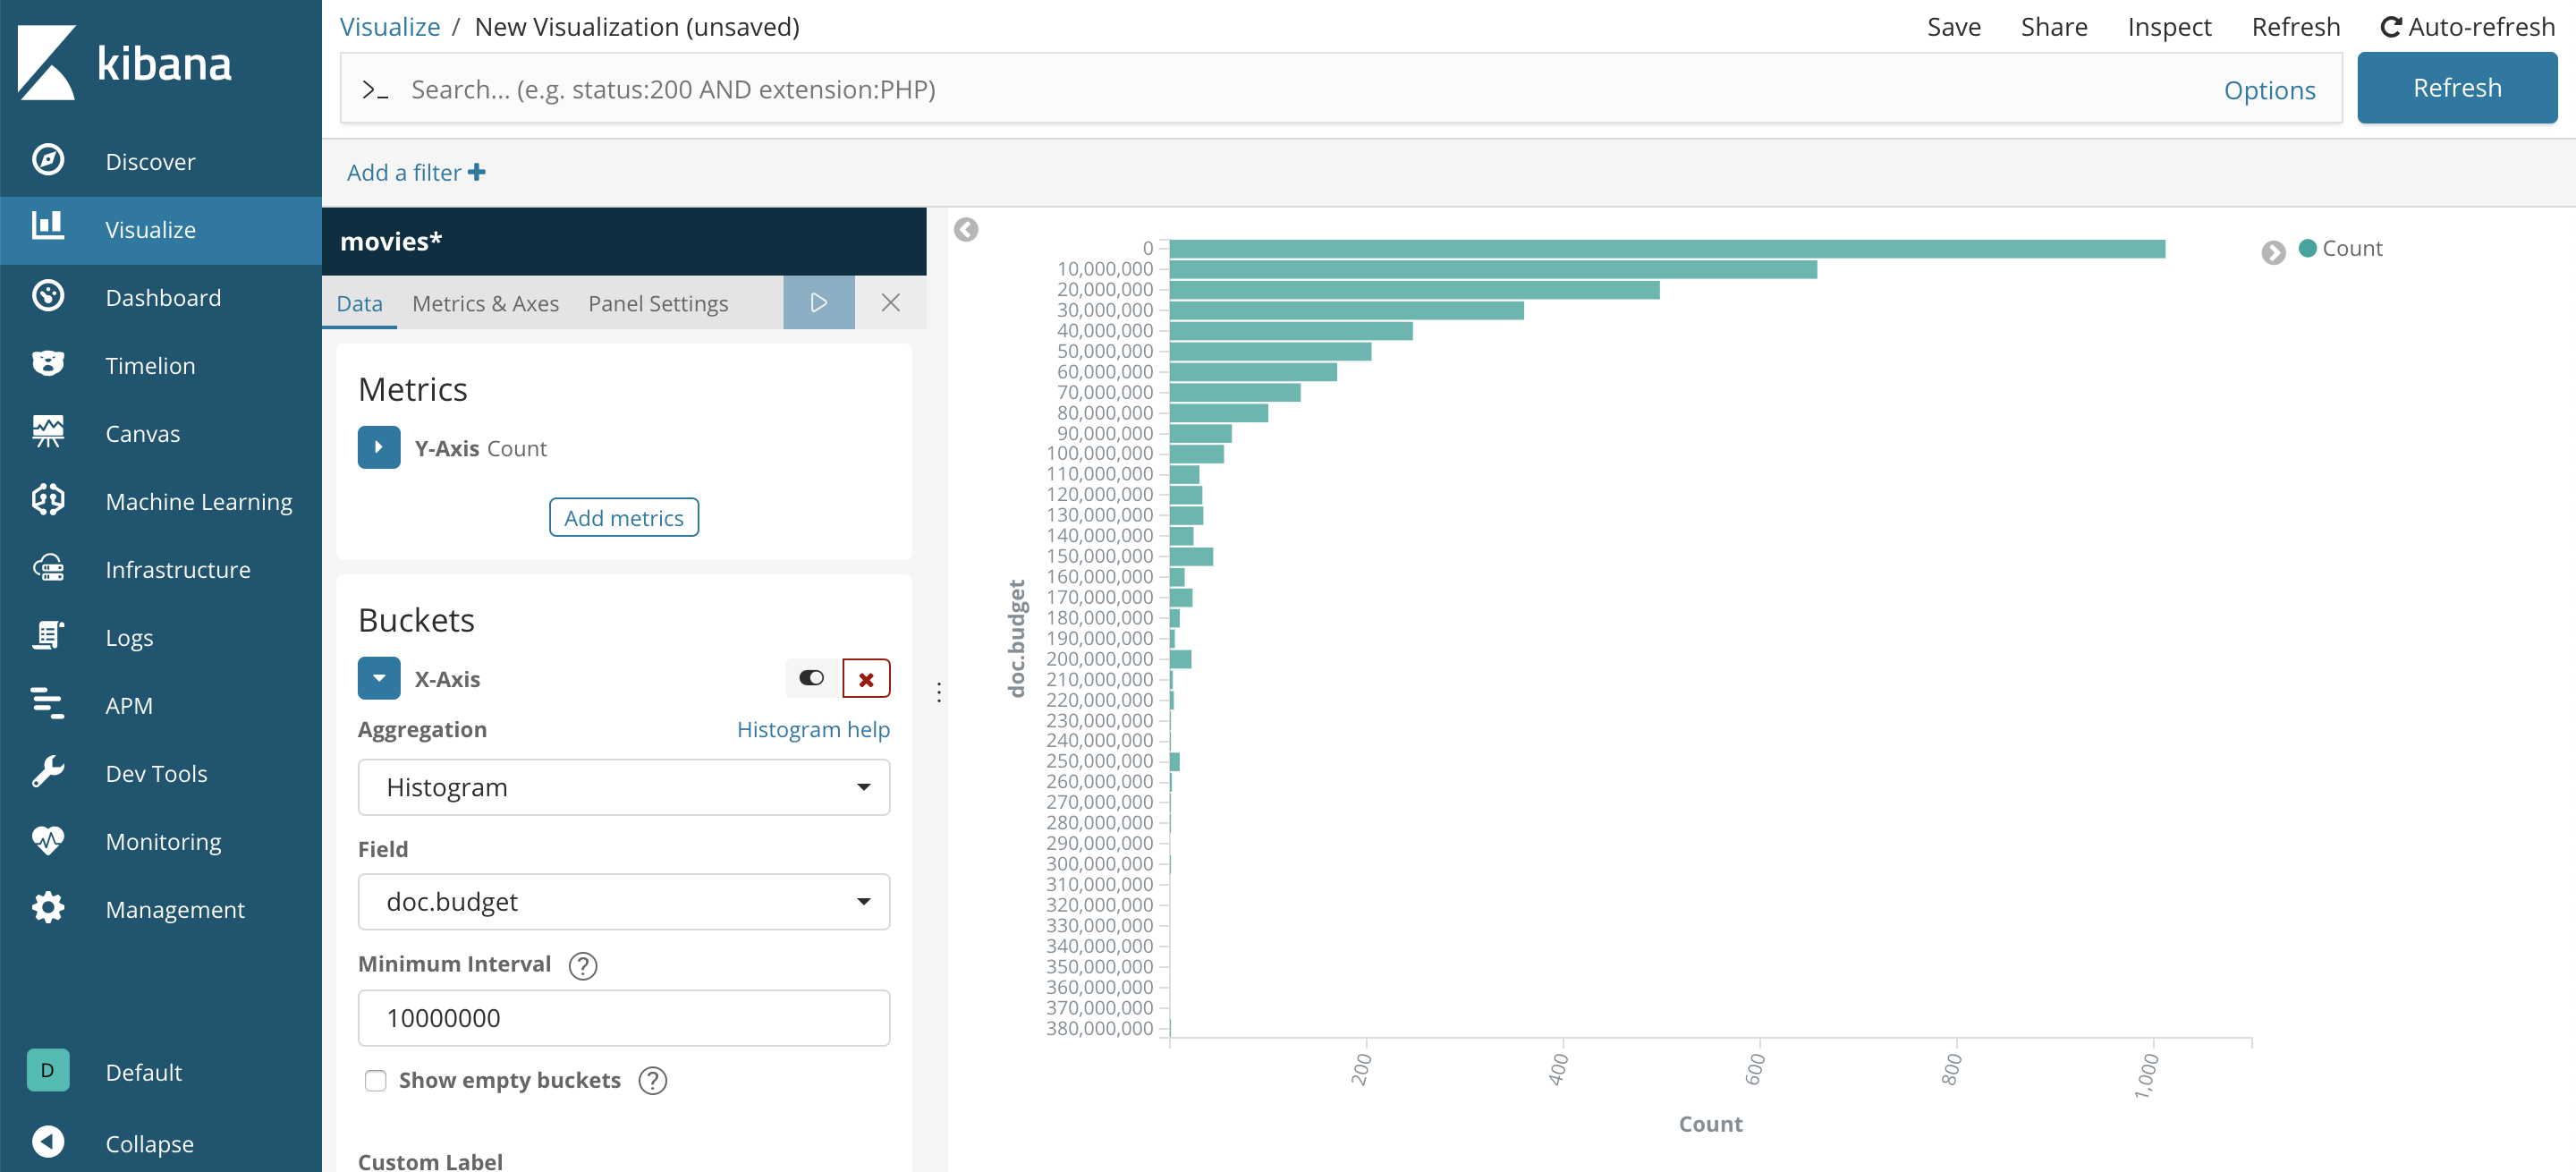

In [44]:
Image("./img/budget.png")

Ou encore des genres des différents films

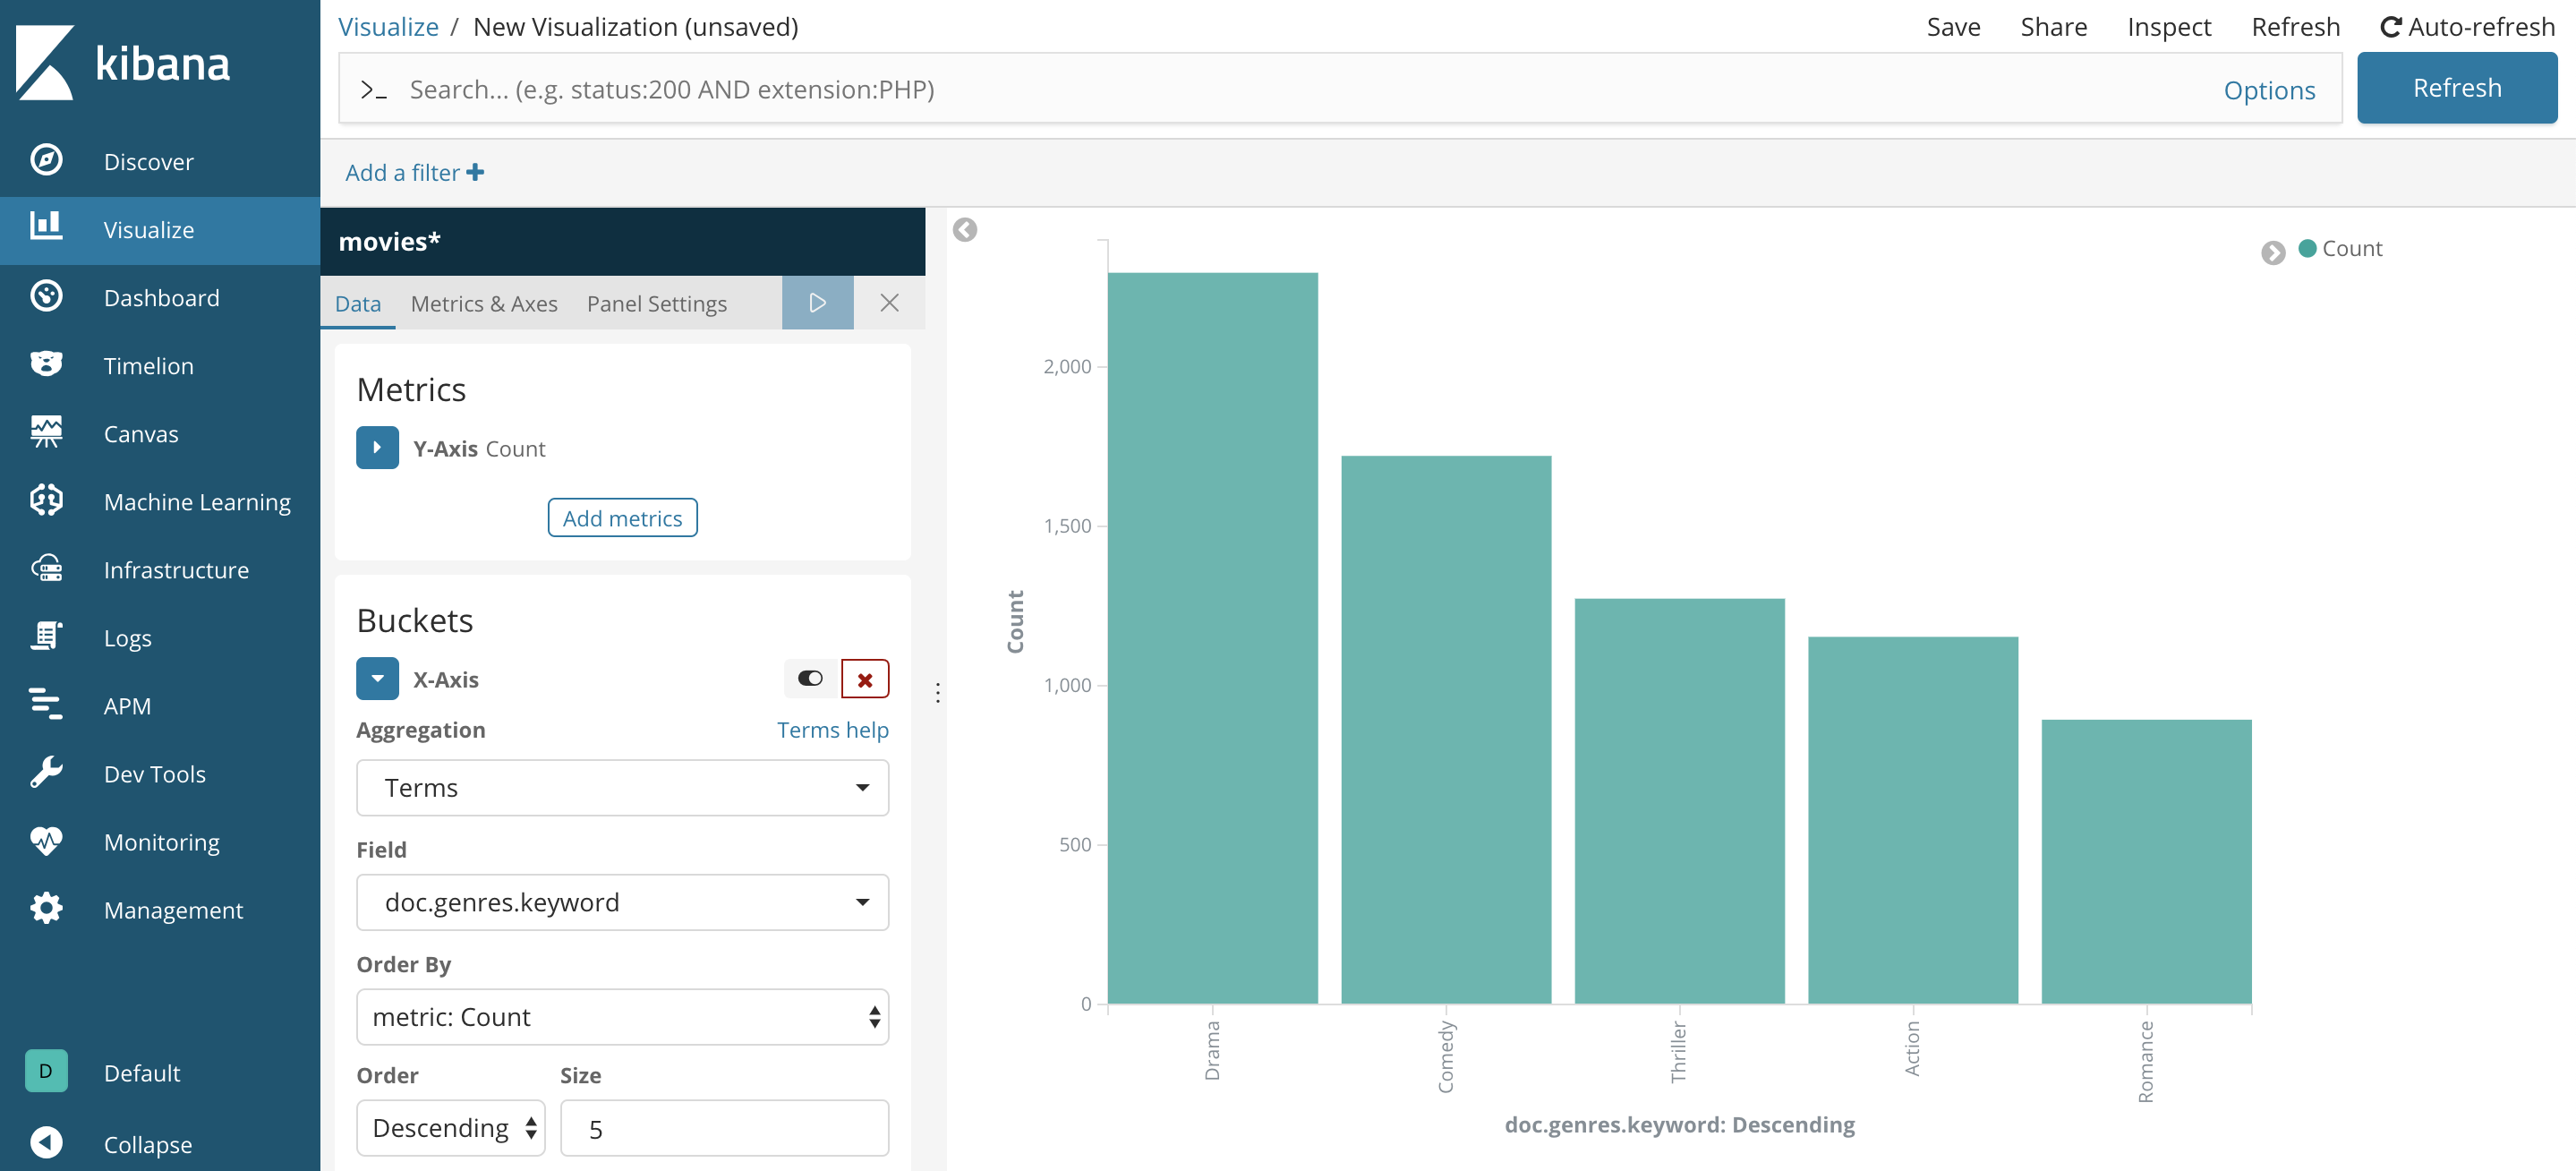

In [45]:
Image("./img/gender.png")

Retournons maintenant un peu dans notre code pour commencer à utiliser ses données. Il va maintenant falloir se plonger dans les requêtes ElasticSearch. Ce n'est pas la choise la plus aisée, elles deviennent vite illisibles et complexes. 

In [46]:
QUERY = {
    "query": {
        "match_all": {}
    }
}

Cette requête simple permet de récupérer l'intégralité des documents d'un index.

In [47]:
QUERY = {
  "query": {
    "term" : { 
        "title" : "superman"} 
  }
}

Cette seconde requête permet de récupérer tous les documents dont le titre contient `SuperMan`.

In [48]:
result = es_client.search(index="movies", body=QUERY)
[elt['_source']['title'] for elt in result["hits"]["hits"]]

['Superman',
 'Superman Returns',
 'Superman II',
 'Superman III',
 'Batman v Superman: Dawn of Justice',
 'Superman IV: The Quest for Peace']

On veut maintenant chercher tous les films contenant `SuperMan` mais qui ne contiennent pas `Batman`. Pour cela on est forcé d'utilisé une requête composée appelée `bool query`  elle permet de transformer chaque requête en un filtre booléen. 

In [49]:
QUERY = {
  "query": {
    "bool" : {
      "must" : {
        "term" : { "title" : "superman" }
      },
      "must_not" : {
                  "term" : { "title" : "batman" }
      }
  }
}
}

In [50]:
result = es_client.search(index="movies", body=QUERY)
[elt['_source']['title'] for elt in result["hits"]["hits"]]

['Superman',
 'Superman Returns',
 'Superman II',
 'Superman III',
 'Superman IV: The Quest for Peace']

On peut encore réduire les resultats en filtrant sur le budget du film. On veut en plus des films de SuperMan sans Batman récupérer les films qui on eu un budget de plus de ou égal à 20M  et moins de 55M.

In [51]:
QUERY = {
  "query": {
    "bool" : {
      "must" : [
          {
        "term" : { "title" : "superman" }},
        {"range" : {
          "budget" : { "gte" : 20000000, "lt" : 55000000 }
        }}
      ],
      "must_not" : {
                  "term" : { "title" : "batman" }
      }
  }
}
}

In [52]:
result = es_client.search(index="movies", body=QUERY)
{elt['_source']['title']:elt['_source']['budget']  for elt in result["hits"]["hits"]}

{'Superman II': 54000000, 'Superman III': 39000000}

Si on veut faire une recherche dans plusieurs champs de chaque document de l'index on peut faire une requête de `multi_match`

In [53]:
QUERY = {
  "query": {
    "multi_match" : {
      "query":    "Smith",
      "fields": [ "title", "overview" ] 
    }
  }
}

In [54]:
result = es_client.search(index="movies", body=QUERY)
[elt['_source']['title']  for elt in result["hits"]["hits"]]

['Mr. Smith Goes to Washington',
 'The New World',
 'Infamous',
 'Mr. & Mrs. Smith',
 'Growing Up Smith',
 'The Matrix Revolutions',
 'Roger & Me',
 'Pocahontas',
 'The Dead Zone',
 'Two Can Play That Game']

On peut vouloir trier les résultats selon la popularité par exemple.

In [55]:
QUERY = {
  "query": {
    "multi_match" : {
      "query":    "Smith",
      "fields": [ "title", "overview" ] 
    }
  },
    "sort" : [
        { "popularity" : {"order" : "desc"}}
    ]
}

In [56]:
result = es_client.search(index="movies", body=QUERY)
{elt['_source']['title']:elt['_source']['popularity']  for elt in result["hits"]["hits"]}

{'The Matrix Revolutions': 73.313918,
 'The Matrix Reloaded': 70.78591,
 'Men in Black 3': 52.035179,
 'Pocahontas': 47.845589000000004,
 'Mr. & Mrs. Smith': 44.635452,
 'I Am Number Four': 43.450266,
 '8 Mile': 32.798571,
 'The New World': 19.106154,
 'The Dead Zone': 16.785120000000003,
 'Mr. Smith Goes to Washington': 12.2624}

ElasticSearch gère aussi bien les dates. On peut vouloir trier par date de sortie.

In [57]:
QUERY = {
  "query": {
    "multi_match" : {
      "query":    "Smith",
      "fields": [ "title", "overview" ] 
    }
  },
    "sort" : [
        { "release_date" : {"order" : "desc"}}
    ]
}

In [58]:
result = es_client.search(index="movies", body=QUERY)
{elt['_source']['title']:elt['_source']['release_date']  for elt in result["hits"]["hits"]}

{'Growing Up Smith': '2017-02-03',
 'Captive': '2015-09-17',
 'Men in Black 3': '2012-05-23',
 'I Am Number Four': '2011-02-18',
 'Justin Bieber: Never Say Never': '2011-02-11',
 'Yogi Bear': '2010-12-11',
 'Gunless': '2010-04-30',
 'Emma': '2009-10-11',
 'Infamous': '2006-11-16',
 'The New World': '2005-12-25'}

## Aggregations

Les aggregations sont des requêtes complexes mais qui permettent de faire des opérations très rapides sur les données. 
La syntaxe devient très vite complexe. Par exemple, pour récupérer le nombre de film par genre. 

In [59]:
QUERY = {
    "aggs": {
    "count_gender": {
      "terms": {
        "field": "genres.keyword",
        "size": 5,
        "order": {
          "_count": "desc"
        }
      }
        }
  }
}

In [60]:
result = es_client.search(index="movies", body=QUERY)
result["aggregations"]["count_gender"]["buckets"]

[{'key': 'Drama', 'doc_count': 2297},
 {'key': 'Comedy', 'doc_count': 1722},
 {'key': 'Thriller', 'doc_count': 1274},
 {'key': 'Action', 'doc_count': 1154},
 {'key': 'Romance', 'doc_count': 894}]

Le paramètre size permet de récupérer les N premières aggrégations.

Ensuite si on veut aller plus loin on peut vouloir récupérer la moyenne des budgets par genre. Il faut intégrer un nouveau niveau d'aggregation. Pour cela on utilise la syntaxe suivante. 

In [61]:
QUERY = {
    "aggs": {
        "count_gender": {
            "terms": {
                "field": "genres.keyword",
                "size": 3,
                "order": {
                    "average_budget": "desc"
                }
            },
            "aggs": {
                "average_budget":{
                    "avg" : {
                        "field" : "budget"
                    }
                }
            }
        }
    }
}

In [62]:
result = es_client.search(index="movies", body=QUERY)
result["aggregations"]["count_gender"]["buckets"]

[{'key': 'Animation',
  'doc_count': 234,
  'average_budget': {'value': 74774139.6923077}},
 {'key': 'Adventure',
  'doc_count': 790,
  'average_budget': {'value': 72876523.59248957}},
 {'key': 'Fantasy',
  'doc_count': 424,
  'average_budget': {'value': 71107378.87862797}}]

# Exercice 

In [63]:
import pandas as pd 

In [64]:
df_credits = pd.read_csv("data/tmdb_5000_credits.csv")

In [65]:
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


1) Nettoyer les données de la DataFrame d'acteurs comme précédement.   
2) Merger les deux DataFrame en utilisant l'identifiant du film.   
3) Créer un nouvel Index `augmented_movies` similaire à l'index précédant mais en ajoutant les données des acteurs.     
4) Créer une fonction permettant de trouver tous les films d'un acteur.   
5) Trouver quel acteur à jouer dans les films avec les plus gros budgets. 
6) Réaliser, sur Kibana, 3 graphiques de votre choix